# Baseline

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [11]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
import seaborn as sns

In [3]:
from thesis_lib.utils import * 

In [4]:
from thesis_lib.modelling.data import *

#### First we load the data, which is already splitted on train, validation and test sets. 

In [5]:
data = Data().load('data/hospital_dataset')
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


0         False
1         False
2          True
3         False
4         False
          ...  
319145    False
319146    False
319147    False
319148    False
319149    False
Length: 319150, dtype: bool

[Text(0, 0, 'False'), Text(0, 0, 'True')]

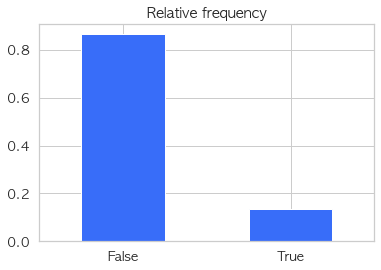

In [33]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
plt.figure(figsize=(6,4))
ax = pd.Series([True if i == 1.0 else False for i in data.train.y ]).value_counts(normalize=True).plot.bar()
ax.set_title('Relative frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

#### Feature selection & feature engineering

##### We need to choose the features we're going to train out model with. As a rule of thumb, in this first experiment, we'll use all the numerical features plus only the categorical features with less than 10 categories (as they're easier to encode)

In [6]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : ['gender'],
                'numerical_features' : ['patient_age']
               }
sample_model = Model(**model_params)
sample_model.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


In [7]:
import time
start = time.time()
sample_model.fit_classifier(**{'max_depth': 7,
                          'random_state': 2020,
                          'n_estimators': 100,
                          'learning_rate': 0.1})
end = time.time()

Training classifier


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	training_set's auc: 0.646196	validation_set's auc: 0.635654
[20]	training_set's auc: 0.646664	validation_set's auc: 0.635083
[30]	training_set's auc: 0.647104	validation_set's auc: 0.635
[40]	training_set's auc: 0.647407	validation_set's auc: 0.634623
[50]	training_set's auc: 0.647673	validation_set's auc: 0.634378
[60]	training_set's auc: 0.647809	validation_set's auc: 0.634348
[70]	training_set's auc: 0.647995	validation_set's auc: 0.634308
[80]	training_set's auc: 0.648121	validation_set's auc: 0.634269
[90]	training_set's auc: 0.648166	validation_set's auc: 0.634476
[100]	training_set's auc: 0.648204	validation_set's auc: 0.634381


In [8]:
perf = sample_model.get_performance_metrics()

training AUC ROC score:  0.648204197033653
validation AUC ROC score:  0.6343806471166661
relative over-fitting:  0.021325918561229534


In [9]:
n = sample_model.n_features

In [10]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([1, 
                 'baseline', 
                 'gdbt', 
                 n,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

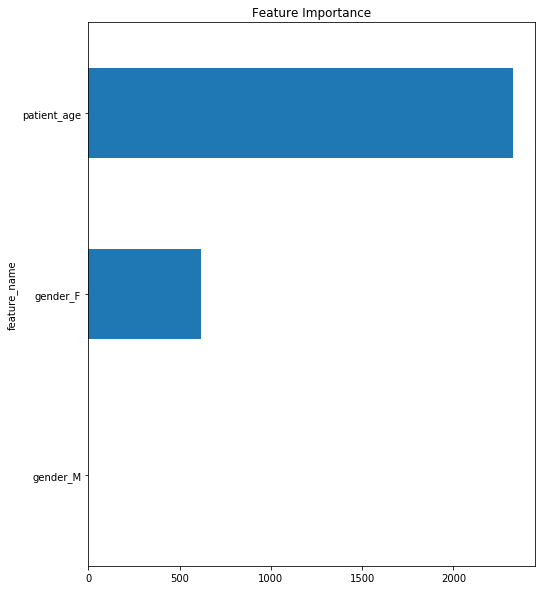

In [11]:
sample_model.plot_feature_importance()

In [44]:
## Example: plot lgbm tree

In [59]:
booster = sample_model.classifier.lgbm_classifier
tree_plot = lgbm.create_tree_digraph(booster,1,
    directory= '/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital/experiments/baseline/',
    filename='lgbm_baseline_tree',
    format='png')

In [60]:
import lightgbm as lgbm

In [61]:
tree_plot.render(view=True)

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/subprocess.py:883: ResourceWarning: subprocess 61723 is still running
  ResourceWarning, source=self)


'/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital/experiments/baseline/lgbm_baseline_tree.png'